In [180]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct  4 17:57:07 2025

@author: coletamburri
"""


from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib as mpl
#import tol_colors
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.io import readsav
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy


def normalize(arr):
    norm_arr = []
    minimum = np.nanmin(arr)
    maximum = np.nanmax(arr)
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr

def normalize_range(arr,lowlim=0,highlim=-1):
    norm_arr = []
    minimum = np.nanmin(arr[lowlim:highlim])
    maximum = np.nanmax(arr[lowlim:highlim])
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr    

c=2.99e5
lamb0 = 396.847
lamb1 = 397.01
lamb2 = 486.1
mu1 = 0.4760111410077789
mu2 = 0.4266927415494022
mu3=.54
muhead = 1

#ViSP instrument
fwhm = .003 # in nm # 0.003 is from the convolution and comparison to atlas, 
            #but 0.01 makes RADYN/DKIST match a lot better? extra gaussian impact somewhere?
            # 0.001 to preserve shape of Hbeta in care for deep heating...
flagh20 = 1
flagh20sum = 0

#only one of the following should be 1
flagb = 0
flagvt = 0
flagt = 0

hepwl=397.01

heplowh20 = 690
hephighh20 = 850

caII_low = 600
caII_high = 700
hep_low = 730
hep_high = 900

hbeta_low = 500
hbeta_high = 650

lowvisp=148
highvisp=148+91
lowvisp_later=148+(8*91)
highvisp_later=148+(9*91)
#lowvisp=0
#highvisp=-1

hbeta_core=486.137
caii_core = 396.847
hep_core = 397.01

def veltrans(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian(x, c1, mu1, sigma1):
    res = c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

def gaussfit(params,selwl,sel):
    fit = gaussian( selwl, params )
    return (fit - sel)

def double_gaussian( x, c1, mu1, sigma1, c2, mu2, sigma2 ):
    res =   (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )) \
          + (c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    return res

def tocgs(self, w, s):
    clight=2.99792458e10         #speed of light [cm/s]
    joule_2_erg=1e7
    aa_to_cm=1e-8
    s *=joule_2_erg/aa_to_cm # from Watt /(cm2 ster AA) to erg/(s cm2 ster cm)
    s *=(w*aa_to_cm)**2/clight   # to erg/
    return s

def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

#example convolution with gaussian psf
def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr

#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range):
   
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    #dw=new_dispersion_range[1]-new_dispersion_range[0]
    #dw=dw
    #tw=(np.arange(ntw)-ntw//2)*dw
    
    stddev_pixels = fwhm/(new_dispersion_range[1]-new_dispersion_range[0])
    gaussian_kernel = Gaussian1DKernel(stddev=stddev_pixels)
   	
    #psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    #yconv = convolve(yatlas, psf, mode='same', method='fft')
    yconv = convolve(yatlas,gaussian_kernel)
    
    return yconv

def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.nm)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

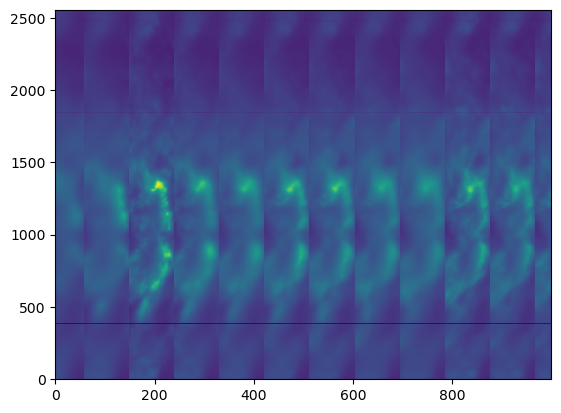

In [179]:
dkist_avg_full = np.mean(dkist_file['flare'][:,caII_low:caII_high,:],1)
fig,ax=plt.subplots()
ax.pcolormesh(np.transpose(dkist_avg_full))

In [3]:
#load DKIST spectra
dkist_file = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSP_spectra_processed_11Aug24_CaII.npz'
dkist_file = np.load(dkist_file)




In [15]:
dkist_wl = dkist_file['wl']
dkist_int = dkist_file['flare'][lowvisp:highvisp,:,:]

dkist_avg = np.mean(dkist_int[:,caII_low:caII_high,:],1)
dkist_time = dkist_file['time']

In [181]:
dkist_int_later = dkist_file['flare'][lowvisp_later:highvisp_later,:,:]


In [20]:
dkist_coord_file = '/Users/coletamburri/Desktop/ViSPcoords.npz'
dkist_coords = np.load(dkist_coord_file)

xarr_CaII = dkist_coords['xarr_caII']
yarr_CaII = dkist_coords['yarr_caII']

xarr_hbeta = dkist_coords['xarr_hbeta']
yarr_hbeta = dkist_coords['yarr_hbeta']

In [33]:
#load DKIST spectra
dkist_filehb = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSP_spectra_processed_11Aug24_Hbeta.npz'
dkist_filehb = np.load(dkist_filehb)


dkist_wlhb = dkist_filehb['wl']
dkist_inthb = dkist_filehb['flare'][lowvisp:highvisp,:,:]
dkist_avghb = np.mean(dkist_inthb[lowvisp:highvisp,hbeta_low:hbeta_high,:],1)
dkist_timehb = dkist_filehb['time']

In [182]:
dkist_inthb_later = dkist_filehb['flare'][lowvisp_later:highvisp_later,:,:]


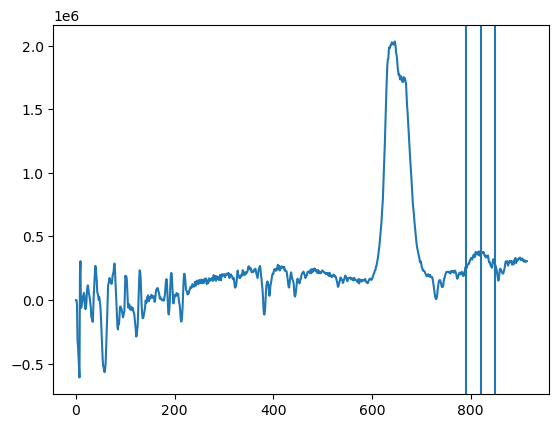

In [58]:
#blue core red, Ca II H
sample = dkist_int[50,:,1000]
plt.plot(sample)
plt.axvline(790)
plt.axvline(820)
plt.axvline(850)

In [ ]:
#blue core red, H-beta
sample = dkist_inthb[0,:,0]
plt.plot(sample)
plt.axvline(600)
plt.axvline(650)
plt.axvline(700)

In [16]:
np.shape(dkist_int)

(91, 915, 2556)

In [17]:
blue = 600
core = 650
red = 700

blue_CaII = dkist_int[:,blue,:]
core_CaII = dkist_int[:,core,:]
red_CaII = dkist_int[:,red,:]

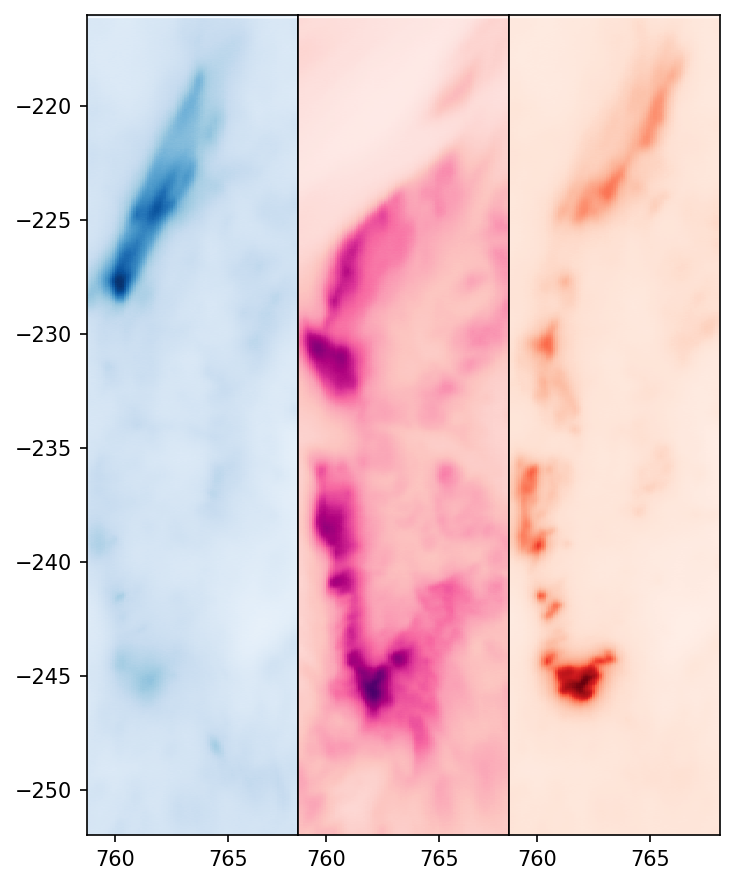

In [75]:
fig,ax=plt.subplots(1,3,figsize=(5,6),dpi=150);
ax.flatten()[0].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(blue_CaII),cmap='Blues')
ax.flatten()[1].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(core_CaII),cmap='RdPu')
ax.flatten()[2].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(red_CaII),cmap='Reds')

ax.flatten()[0].set_ylim([-252,-216])
ax.flatten()[1].set_ylim([-252,-216])
ax.flatten()[2].set_ylim([-252,-216])

ax.flatten()[1].set_yticks([])
ax.flatten()[2].set_yticks([])

fig.tight_layout()
fig.subplots_adjust(wspace=0)

In [161]:
bluehb = 505
corehb = 567
redhb = 630

blue_hb = dkist_inthb[:,bluehb,:-1]
core_hb = dkist_inthb[:,corehb,:-1]
red_hb = dkist_inthb[:,redhb,:-1]

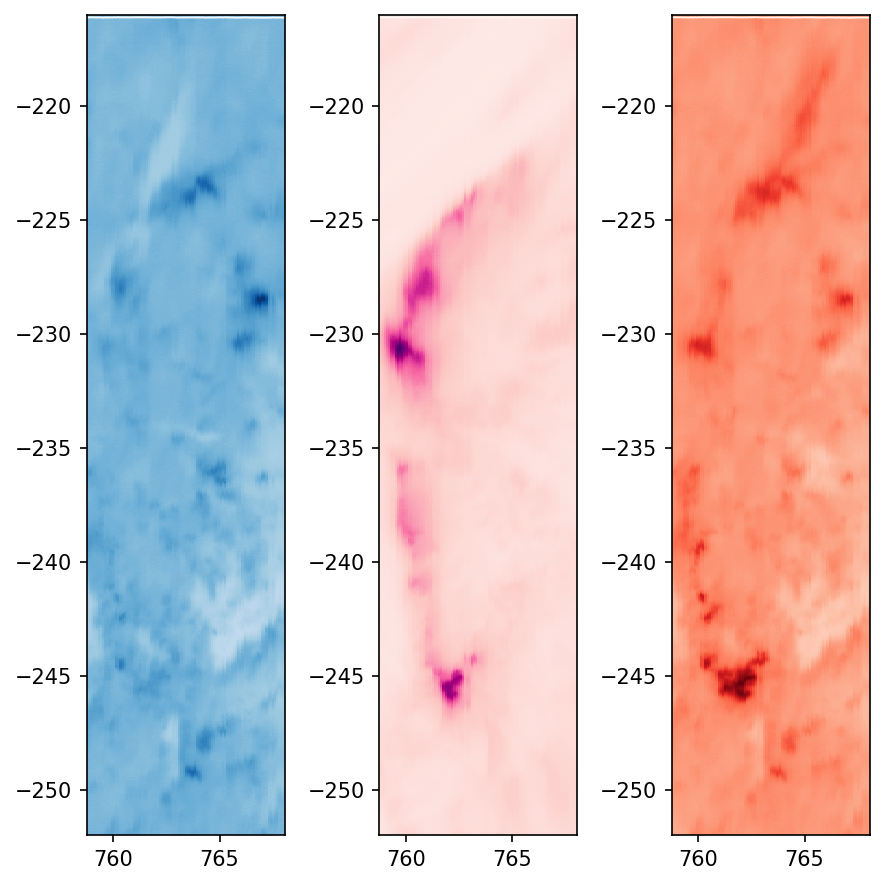

In [162]:
fig,ax=plt.subplots(1,3,figsize=(6,6),dpi=150);
ax.flatten()[0].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(blue_hb),cmap='Blues')
ax.flatten()[1].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(core_hb),cmap='RdPu')
ax.flatten()[2].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(red_hb),cmap='Reds')

ax.flatten()[0].set_ylim([-252,-216])
ax.flatten()[1].set_ylim([-252,-216])
ax.flatten()[2].set_ylim([-252,-216])

fig.tight_layout()

In [150]:
bluehep = 770
corehep = 830
redhep = 880

blue_hep = dkist_int[:,bluehep,:]
core_hep = dkist_int[:,corehep,:]
red_hep = dkist_int[:,redhep,:]

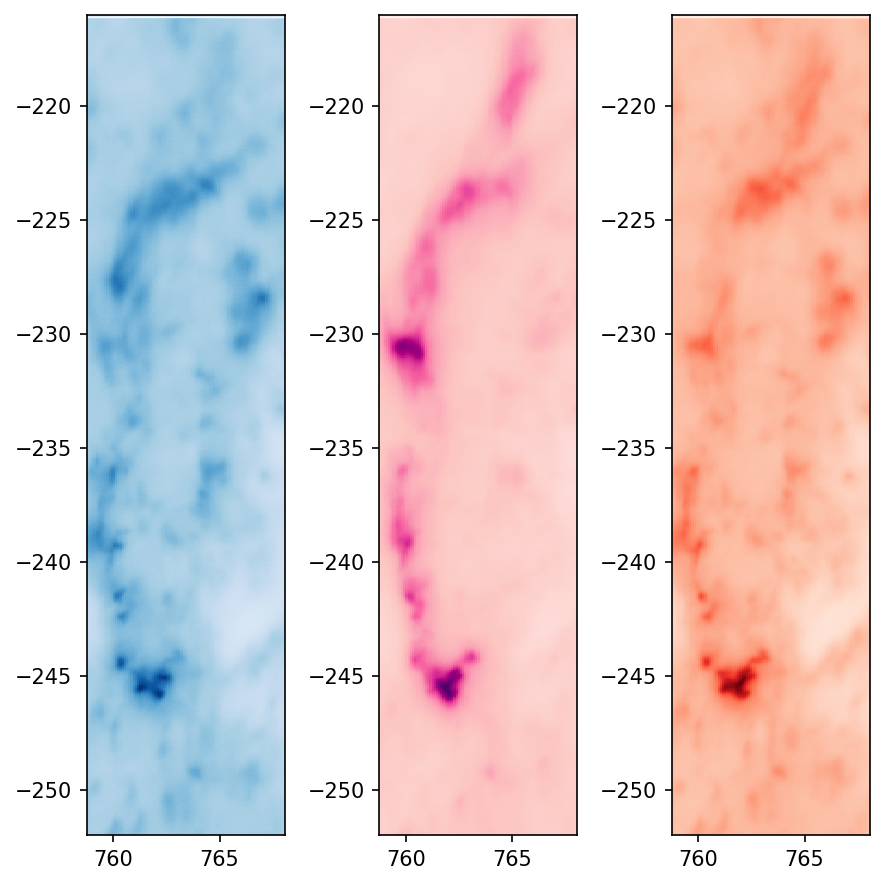

In [151]:
fig,ax=plt.subplots(1,3,figsize=(6,6),dpi=150);
ax.flatten()[0].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(blue_hep),cmap='Blues')
ax.flatten()[1].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(core_hep),cmap='RdPu')
ax.flatten()[2].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(red_hep),cmap='Reds')

ax.flatten()[0].set_ylim([-252,-216])
ax.flatten()[1].set_ylim([-252,-216])
ax.flatten()[2].set_ylim([-252,-216])

fig.tight_layout()

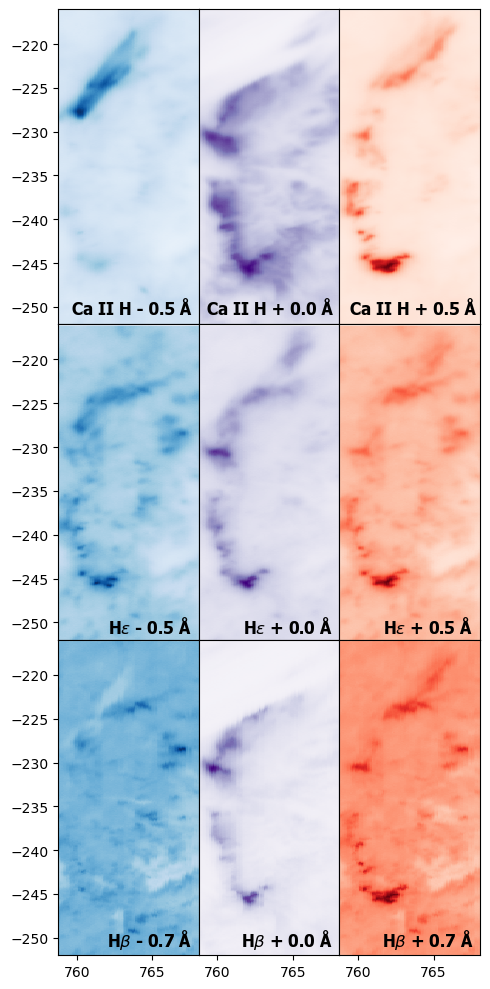

In [173]:
fig,ax=plt.subplots(3,3,figsize=(5,10),dpi=100);
ax.flatten()[0].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(blue_CaII),cmap='Blues')
ax.flatten()[1].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(core_CaII),cmap='Purples')
ax.flatten()[2].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(red_CaII),cmap='Reds')
ax.flatten()[3].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(blue_hep),cmap='Blues')
ax.flatten()[4].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(core_hep),cmap='Purples')
ax.flatten()[5].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(red_hep),cmap='Reds')
ax.flatten()[6].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(blue_hb),cmap='Blues')
ax.flatten()[7].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(core_hb),cmap='Purples')
ax.flatten()[8].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(red_hb),cmap='Reds')

ax.flatten()[0].set_ylim([-252,-216])
ax.flatten()[1].set_ylim([-252,-216])
ax.flatten()[2].set_ylim([-252,-216])
ax.flatten()[3].set_ylim([-252,-216])
ax.flatten()[4].set_ylim([-252,-216])
ax.flatten()[5].set_ylim([-252,-216])
ax.flatten()[6].set_ylim([-252,-216])
ax.flatten()[7].set_ylim([-252,-216])
ax.flatten()[8].set_ylim([-252,-216])

ax.flatten()[1].set_yticks([])
ax.flatten()[2].set_yticks([])
ax.flatten()[4].set_yticks([])
ax.flatten()[5].set_yticks([])
ax.flatten()[7].set_yticks([])
ax.flatten()[8].set_yticks([])

ax.flatten()[0].set_xticks([])
ax.flatten()[1].set_xticks([])
ax.flatten()[2].set_xticks([])
ax.flatten()[3].set_xticks([])
ax.flatten()[4].set_xticks([])
ax.flatten()[5].set_xticks([])

# The text string to display


# Place the text box in the upper right corner
ax.flatten()[0].text(0.95, 0.075, r'Ca II H - '+str(10*round(caii_core-dkist_wl[blue],2))+' \u00C5', transform=ax.flatten()[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[1].text(0.95, 0.075,r'Ca II H + '+ str(10*round(dkist_wl[core]-caii_core,2))+' \u00C5', transform=ax.flatten()[1].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[2].text(0.97, 0.075,r'Ca II H + '+ str(10*round(dkist_wl[red]-caii_core,2))+' \u00C5', transform=ax.flatten()[2].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[3].text(0.95, 0.075,r'H$\epsilon$ - '+ str(10*round(hep_core-dkist_wl[bluehep],2))+' \u00C5', transform=ax.flatten()[3].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[4].text(0.95, 0.075,r'H$\epsilon$ + '+ str(10*round(dkist_wl[corehep]-hep_core,2))+' \u00C5', transform=ax.flatten()[4].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[5].text(0.95, 0.075,r'H$\epsilon$ + '+ str(10*round(dkist_wl[redhep]-hep_core,2))+' \u00C5', transform=ax.flatten()[5].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
# ax.flatten()[6].text(0.95, 0.09,r'H$\beta$ - '+ str(10*round(hbeta_core-dkist_wlhb[bluehb],2))+' \u00C5', transform=ax.flatten()[6].transAxes,
#         fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
# ax.flatten()[7].text(0.95, 0.09,r'H$\beta$ + '+ str(10*round(dkist_wlhb[corehb]-hbeta_core,2))+' \u00C5', transform=ax.flatten()[7].transAxes,
#         fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
# ax.flatten()[8].text(0.95, 0.09,r'H$\beta$ + '+str(10*round(dkist_wlhb[redhb]-hbeta_core,2))+' \u00C5', transform=ax.flatten()[8].transAxes,
#         fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[6].text(0.95, 0.09,r'H$\beta$ - 0.7 '+'\u00C5', transform=ax.flatten()[6].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[7].text(0.95, 0.09,r'H$\beta$ + 0.0 '+'\u00C5', transform=ax.flatten()[7].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[8].text(0.95, 0.09,r'H$\beta$ + 0.7 '+'\u00C5', transform=ax.flatten()[8].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')



fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

In [183]:
blue_CaII_later = dkist_int_later[:,blue,:]
core_CaII_later = dkist_int_later[:,core,:]
red_CaII_later = dkist_int_later[:,red,:]

blue_hb_later = dkist_inthb_later[:,bluehb,:-1]
core_hb_later = dkist_inthb_later[:,corehb,:-1]
red_hb_later = dkist_inthb_later[:,redhb,:-1]

blue_hep_later = dkist_int_later[:,bluehep,:]
core_hep_later = dkist_int_later[:,corehep,:]
red_hep_later = dkist_int_later[:,redhep,:]

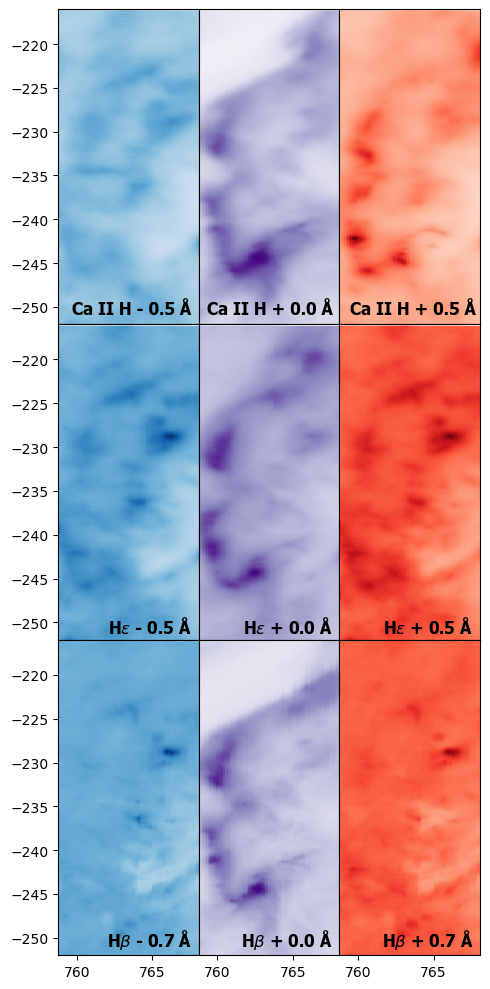

In [184]:
fig,ax=plt.subplots(3,3,figsize=(5,10),dpi=100);
ax.flatten()[0].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(blue_CaII_later),cmap='Blues')
ax.flatten()[1].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(core_CaII_later),cmap='Purples')
ax.flatten()[2].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(red_CaII_later),cmap='Reds')
ax.flatten()[3].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(blue_hep_later),cmap='Blues')
ax.flatten()[4].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(core_hep_later),cmap='Purples')
ax.flatten()[5].pcolormesh(xarr_CaII,yarr_CaII,np.transpose(red_hep_later),cmap='Reds')
ax.flatten()[6].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(blue_hb_later),cmap='Blues')
ax.flatten()[7].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(core_hb_later),cmap='Purples')
ax.flatten()[8].pcolormesh(xarr_hbeta,yarr_hbeta,np.transpose(red_hb_later),cmap='Reds')

ax.flatten()[0].set_ylim([-252,-216])
ax.flatten()[1].set_ylim([-252,-216])
ax.flatten()[2].set_ylim([-252,-216])
ax.flatten()[3].set_ylim([-252,-216])
ax.flatten()[4].set_ylim([-252,-216])
ax.flatten()[5].set_ylim([-252,-216])
ax.flatten()[6].set_ylim([-252,-216])
ax.flatten()[7].set_ylim([-252,-216])
ax.flatten()[8].set_ylim([-252,-216])

ax.flatten()[1].set_yticks([])
ax.flatten()[2].set_yticks([])
ax.flatten()[4].set_yticks([])
ax.flatten()[5].set_yticks([])
ax.flatten()[7].set_yticks([])
ax.flatten()[8].set_yticks([])

ax.flatten()[0].set_xticks([])
ax.flatten()[1].set_xticks([])
ax.flatten()[2].set_xticks([])
ax.flatten()[3].set_xticks([])
ax.flatten()[4].set_xticks([])
ax.flatten()[5].set_xticks([])

# The text string to display


# Place the text box in the upper right corner
ax.flatten()[0].text(0.95, 0.075, r'Ca II H - '+str(10*round(caii_core-dkist_wl[blue],2))+' \u00C5', transform=ax.flatten()[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[1].text(0.95, 0.075,r'Ca II H + '+ str(10*round(dkist_wl[core]-caii_core,2))+' \u00C5', transform=ax.flatten()[1].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[2].text(0.97, 0.075,r'Ca II H + '+ str(10*round(dkist_wl[red]-caii_core,2))+' \u00C5', transform=ax.flatten()[2].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[3].text(0.95, 0.075,r'H$\epsilon$ - '+ str(10*round(hep_core-dkist_wl[bluehep],2))+' \u00C5', transform=ax.flatten()[3].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[4].text(0.95, 0.075,r'H$\epsilon$ + '+ str(10*round(dkist_wl[corehep]-hep_core,2))+' \u00C5', transform=ax.flatten()[4].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[5].text(0.95, 0.075,r'H$\epsilon$ + '+ str(10*round(dkist_wl[redhep]-hep_core,2))+' \u00C5', transform=ax.flatten()[5].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
# ax.flatten()[6].text(0.95, 0.09,r'H$\beta$ - '+ str(10*round(hbeta_core-dkist_wlhb[bluehb],2))+' \u00C5', transform=ax.flatten()[6].transAxes,
#         fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
# ax.flatten()[7].text(0.95, 0.09,r'H$\beta$ + '+ str(10*round(dkist_wlhb[corehb]-hbeta_core,2))+' \u00C5', transform=ax.flatten()[7].transAxes,
#         fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
# ax.flatten()[8].text(0.95, 0.09,r'H$\beta$ + '+str(10*round(dkist_wlhb[redhb]-hbeta_core,2))+' \u00C5', transform=ax.flatten()[8].transAxes,
#         fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[6].text(0.95, 0.09,r'H$\beta$ - 0.7 '+'\u00C5', transform=ax.flatten()[6].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[7].text(0.95, 0.09,r'H$\beta$ + 0.0 '+'\u00C5', transform=ax.flatten()[7].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')
ax.flatten()[8].text(0.95, 0.09,r'H$\beta$ + 0.7 '+'\u00C5', transform=ax.flatten()[8].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',fontweight='bold',font='Tahoma')



fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

In [189]:
# first time - start and end
print(dkist_time[148])
print(dkist_time[148+90])

2024-08-11T22:33:19.500789
2024-08-11T22:33:24.015270


In [190]:
# second time - start and end
print(dkist_time[148+8*91])
print(dkist_time[148+8*91+90])

2024-08-11T22:36:07.539808
2024-08-11T22:36:12.054289
